In [13]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")

In [412]:
def initLearningPhase(n_trials_per_choice,values):
    '''
        Generate trials for the learning phase that have a
        uniform number of presentations across each choice combination
        
        n_trials_per_choice: Number of trials that will be presented for each choice combo
        values: dictionary of values for each level in a category
    
    '''
    choice_combos = list(itertools.combinations(values.keys(), 2))

    choices = [i for j in [choice_combos] * n_trials_per_choice for i in j]

    def genCatTrials():
        choices_out = choices.copy()
        np.random.shuffle(choices_out)
        return choices_out

    trials = {'face':genCatTrials(),
              'scene':genCatTrials(),
              'bpart':genCatTrials()}

    n_trials = len(choices) * len(trials.keys())
    
    return n_trials, trials


def initTestingPhase(n_trials=None,n_bins=None):
    '''
        Generate trials for the testing phase that have a 
        uniformly distributed delta value
        
        n_trials: Number of total trials in the testing phase
        n_bins: Number of bins to split delta value evenly across
    
    '''
    
    def genOption():
        option = np.random.choice(list(values.keys()),3)
        option_value = np.sum([values[level] for level in option])
        return option, option_value
    
    n_choices_per_bin = n_trials/n_bins

    max_diff = values['high']*3 - values['low']*3

    bins = np.linspace(-max_diff,max_diff,n_bins)

    bin_counter = dict((el,0) for el in range(0,n_bins))

    testing_trials = {'option1':[],
                      'option2':[],
                      'option1_value':[],
                      'option2_value':[],
                      'delta_value':[]}

    while np.mean(list(bin_counter.values())) != n_choices_per_bin:

        option1, option1_value = genOption()
        option2, option2_value = genOption()

        delta_value = option1_value - option2_value

        curr_bin = np.where(bins <= delta_value)[0][-1]

        if bin_counter[curr_bin] < n_choices_per_bin:

            bin_counter[curr_bin]+=1

            testing_trials["option1"].append(tuple(option1))
            testing_trials["option2"].append(tuple(option2))
            testing_trials["option1_value"].append(option1_value)
            testing_trials["option2_value"].append(option2_value)
            testing_trials["delta_value"].append(delta_value)

    testing_trials = pd.DataFrame.from_dict(testing_trials)
    testing_trials = testing_trials.sample(frac=1).reset_index() # shuffle the trials
    
    return testing_trials

### Simulate the Learning Phase

In [394]:
global values

# the number of trials per level combination in learning phase
n_trials_per_choice = 5 

# the value assigned to each category level
values = {
            'high':9,
            'highmid':6,
            'lowmid':3,
            'low':1
         }

# the strategy artifical agent should take for learing
# options: "random", "Q (haven't done yet)"
learning_strategy = "random"

n_learning_trials, trials = initLearningPhase(n_trials_per_choice=n_trials_per_choice,
                                              values=values)

learn_data = {'trial_number':[],
              'category':[],
              'options':[],
              'choice':[],
              'outcome':[],
              'phase':[]}

for i in range(n_learning_trials):
    categories = [cat for cat in trials.keys() if len(trials[cat]) > 0]
    
    category = np.random.choice(categories)
    options = trials[category].pop()
    
    if learning_strategy == "random":
        # random choice
        choice_index = int(np.round(np.random.uniform()))
    
    choice = options[choice_index]
    
    outcome = values[choice]
    
    learn_data['trial_number'].append(i+1)
    learn_data['category'].append(category)
    learn_data['options'].append(options)
    learn_data['choice'].append(choice)
    learn_data['outcome'].append(outcome)
    learn_data['phase'].append('learning')

learn_data = pd.DataFrame.from_dict(learn_data)

In [395]:
learn_data.head()

,trial_number,category,options,choice,outcome,phase
0,1,face,"(high, low)",high,9,learning
1,2,bpart,"(highmid, lowmid)",lowmid,3,learning
2,3,scene,"(lowmid, low)",low,1,learning
3,4,face,"(high, lowmid)",high,9,learning
4,5,scene,"(lowmid, low)",low,1,learning


---
### Simulate the Testing Phase

In [396]:
# Testing Phase
testing_trials = initTestingPhase(n_trials=100,n_bins=9)
# 9 bins seems to give us the best balance between uniformity and equating presentations of individual combinations

In [410]:
learning_strategy = "random"

n_testing_trials = len(testing_trials)

test_data = {'trial_number':[],
             'face1':[],
             'scene1':[],
             'bodyp1':[],
             'face2':[],
             'scene2':[],
             'bodyp2':[],
             'option1_value':[],
             'option2_value':[],
             'delta_value':[],
             'choice':[],
             'outcome':[],
             'phase':[]}

for i, trial_vals in testing_trials.iterrows():
        
    if learning_strategy == "random":
        choice_number = int(np.round(np.random.uniform()))+1
    
    choice = "option"+str(choice_number)
    outcome = trial_vals[choice+"_value"]
    
    test_data['trial_number'].append(i+1)
    test_data['face1'].append(trial_vals['option1'][0])
    test_data['scene1'].append(trial_vals['option1'][1])
    test_data['bodyp1'].append(trial_vals['option1'][2])
    test_data['face2'].append(trial_vals['option2'][0])
    test_data['scene2'].append(trial_vals['option2'][1])
    test_data['bodyp2'].append(trial_vals['option2'][2])
    test_data['option1_value'].append(trial_vals['option1_value'])
    test_data['option2_value'].append(trial_vals['option2_value'])
    test_data['delta_value'].append(trial_vals['delta_value'])
    test_data['choice'].append(choice)
    test_data['outcome'].append(outcome)
    test_data['phase'].append('testing')

test_data = pd.DataFrame.from_dict(test_data)    

In [411]:
test_data.head()

,trial_number,face1,scene1,bodyp1,face2,scene2,bodyp2,option1_value,option2_value,delta_value,choice,outcome,phase
0,1,high,high,highmid,highmid,highmid,lowmid,24,15,9,option1,24,testing
1,2,low,lowmid,high,low,high,low,13,11,2,option2,11,testing
2,3,highmid,highmid,low,high,high,high,13,27,-14,option2,27,testing
3,4,lowmid,low,highmid,high,high,high,10,27,-17,option1,10,testing
4,5,high,lowmid,highmid,high,lowmid,highmid,18,18,0,option2,18,testing


### Verify that testing delta value is uniformly distributed

In [398]:
testing_trials.head()

,index,option1,option2,option1_value,option2_value,delta_value
0,15,"(high, high, highmid)","(highmid, highmid, lowmid)",24,15,9
1,13,"(low, lowmid, high)","(low, high, low)",13,11,2
2,59,"(highmid, highmid, low)","(high, high, high)",13,27,-14
3,53,"(lowmid, low, highmid)","(high, high, high)",10,27,-17
4,11,"(high, lowmid, highmid)","(high, lowmid, highmid)",18,18,0


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


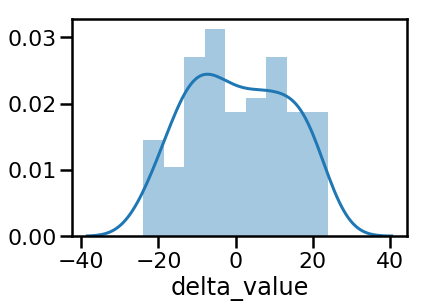

In [372]:
sns.distplot(testing_trials['delta_value'],bins=bins)

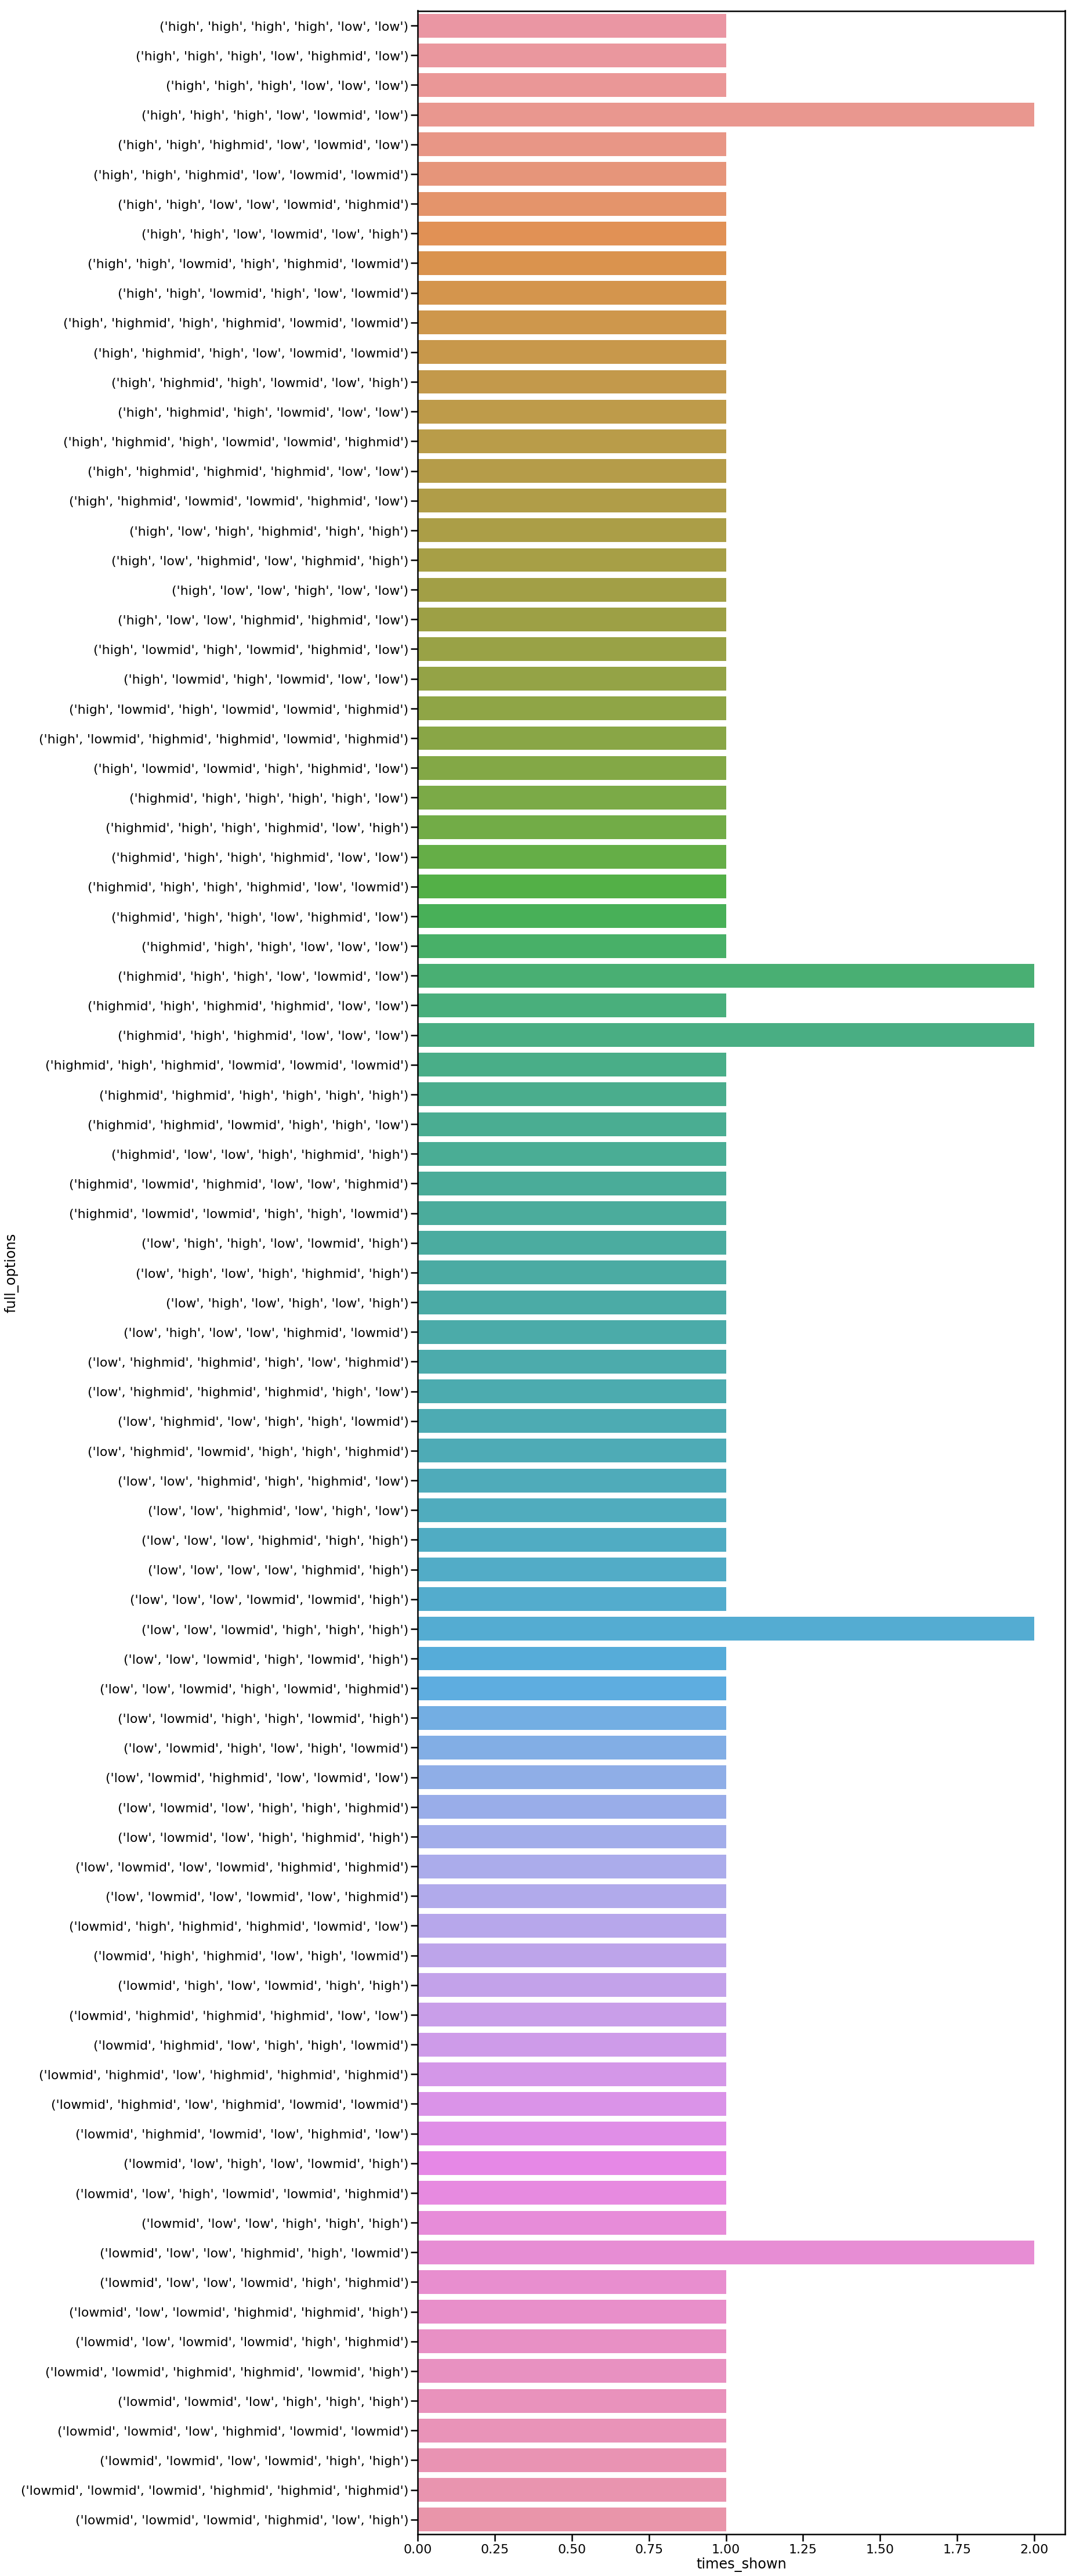

In [373]:
f, ax = plt.subplots(1,1,figsize=(20,80))
testing_combinations = testing_trials.groupby(['option1','option2']).size().reset_index(name="times_shown")
testing_combinations['full_options'] = testing_combinations['option1']+testing_combinations['option2']
sns.barplot(x="times_shown",y="full_options",data=testing_combinations)